In [43]:
%reload_ext Cython

%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import os
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf 

def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

def files_info_to_df(files_info):
    #files_info_arr = [None] * N_EXPERIMENTS
    files_df = pd.DataFrame()
    for experiment_name, experiment_files_info in files_info.items():
        experiment_id = int(re.match(
            "experiment(?P<experiment_id>\d+)", experiment_name
        ).group('experiment_id'))
        
        for file_info in experiment_files_info:
            f = file_info['f']
            files_df = files_df.append(pd.Series({
                'experiment_id': experiment_id,
                'experiment_name': experiment_name,
                'file_id': f.id,
                'n_chunks': f.n_chunks,
                'size': f.size,
                'chunk_size': f.chunks_size[0],
                'success': all(f.acked_chunks),
                'n_sent_chunks': sum(f.shared_chunks)
            }), ignore_index=True)
    return files_df

In [2]:
def fetch_experiment_set(path):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    conf = {}
    files_info = {}
    for experiment_name in os.listdir(path):
        conf_, files_info_, devices_df_, users_df_ = \
            fetch_experiment_data(path+experiment_name+"/")
        
        devices_df_['experiment_name'] = experiment_name
        users_df_['experiment_name'] = experiment_name
        devices_df = devices_df.append(devices_df_, ignore_index=True)
        users_df = users_df.append(users_df_, ignore_index=True)
        conf[experiment_name] = conf_
        files_info[experiment_name] = files_info_
    return conf, files_info, devices_df, users_df

# Mesage IDs are not unique in the dataset! (experiment_id, mes_id) should be
conf, files_info, devices_df, users_df =  fetch_experiment_set("data/random_file_size/")
files_df = files_info_to_df(files_info)
N_EXPERIMENTS = users_df['experiment_id'].max()+1

# File transfer time as a function of size

In [44]:
files_df = files_info_to_df(files_info)
files_df

,chunk_size,experiment_id,experiment_name,file_id,n_chunks,n_sent_chunks,size,success
0,512.0,8.0,experiment8,szmjrxnn3yii,473.0,564.0,242047.0,1.0
1,512.0,8.0,experiment8,3gbh5psw6y6x,802.0,1112.0,410124.0,1.0
2,512.0,8.0,experiment8,665bu8idm9hx,971.0,1338.0,496761.0,1.0
3,512.0,8.0,experiment8,23s0x1129bci,542.0,746.0,277249.0,1.0
4,512.0,8.0,experiment8,lbvbuhybxnao,324.0,589.0,165418.0,1.0
5,512.0,8.0,experiment8,qlogrx2pyk2q,821.0,1202.0,420278.0,1.0
6,512.0,8.0,experiment8,rkfj7jx837a2,341.0,532.0,174187.0,1.0
7,512.0,8.0,experiment8,zal1w533ulkp,110.0,152.0,56276.0,1.0
8,512.0,8.0,experiment8,3knlj122a5x4,426.0,647.0,217899.0,1.0
9,512.0,8.0,experiment8,hnchm9q5vp7l,771.0,1018.0,394284.0,1.0


In [60]:
transfer_time_df = pd.DataFrame()
for _, f in files_df.iterrows():
    data = devices_df[devices_df['file_id'] == f['file_id']]
    transfer_time = data[data['received'] != 0]['t'].max() - \
        data[data['sent'] != 0]['t'].min() 
    
    transfer_time_df = transfer_time_df.append(pd.Series({
        'file_id': f['file_id'],
        't': transfer_time,
        'size': f['size']
    }), ignore_index=True)

transfer_time_df['size'] /= 1024
transfer_time_df

,file_id,size,t
0,szmjrxnn3yii,236.374023,1026.134756
1,3gbh5psw6y6x,400.511719,987.667136
2,665bu8idm9hx,485.118164,1026.859284
3,23s0x1129bci,270.750977,927.579806
4,lbvbuhybxnao,161.541016,977.653964
5,qlogrx2pyk2q,410.427734,1032.130177
6,rkfj7jx837a2,170.104492,977.628324
7,zal1w533ulkp,54.957031,533.827068
8,3knlj122a5x4,212.791992,976.536643
9,hnchm9q5vp7l,385.042969,1029.393705


In [ ]:
sns.set_context('paper')
sns.set(font='serif')
sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [67]:
N_POINTS = 20
bins = np.linspace(
    transfer_time_df['size'].min(), 
    transfer_time_df['size'].max()+.1, num=N_POINTS+1)
times = [None] * N_POINTS
stderr = [None] * N_POINTS
bins_centers = [None] * N_POINTS
for i in range(N_POINTS):
    data = transfer_time_df[(transfer_time_df['size'] >= bins[i]) &
                            (transfer_time_df['size'] < bins[i+1])]['t']
    times[i] = data.mean()
    stderr[i] = data.std()
    bins_centers[i] = bins[i] + (bins[i+1] - bins[i])/2

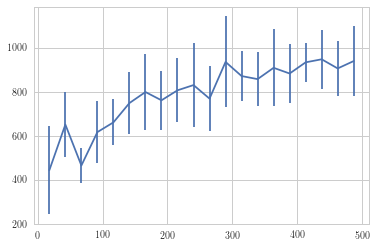

In [83]:
fig, ax = plt.subplots()
#ax.hist(y=times, bins=bins)
ax.errorbar(x=bins_centers, y=times, yerr=stderr)


plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:277: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


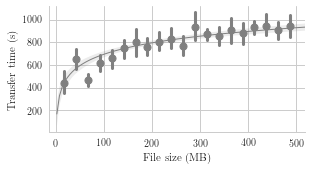

In [126]:
SIZE=4.5
fig, ax = plt.subplots(figsize=(SIZE, SIZE * 9 / 16))
sns.regplot(x="size", y="t", x_bins=bins_centers, data=transfer_time_df, 
            ax=ax, logx=True, color="gray", 
            line_kws={'linewidth':1},
            scatter_kws={'linewidths': 1})

ax.set_xlabel("File size (MB)")
ax.set_ylabel("Transfer time (s)")

sns.despine()
plt.tight_layout()
plt.savefig("outputs/transfer_time_vs_size.pdf")
plt.show()

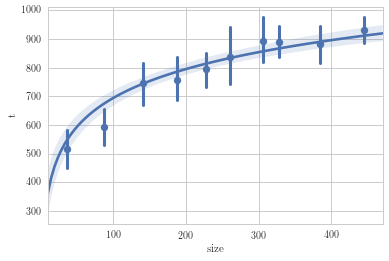

In [109]:
fig, ax = plt.subplots()
sns.regplot(x="size", y="t", x_bins=10, data=transfer_time_df, ax=ax, logx=True)
plt.show()

# RTT Plot (we don't care)

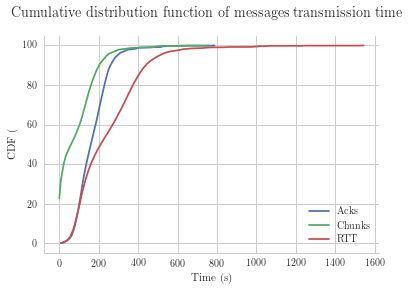

In [108]:
f, ax = plt.subplots()
sns.set_context('paper')
sns.set(font='serif')
sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Plot the cdf
ax.plot(ack_bins[0:-1], ack_cdf, label="Acks")
ax.plot(chunk_bins[0:-1], chunk_cdf, label="Chunks")
ax.plot(rtt_bins[0:-1], rtt_cdf, label="RTT")

ax.set_xlabel('Time (s)')
#ax.set_xlim(0,)
ax.set_ylabel('CDF (%)')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
#ax.set_ylim(0,)
ax.legend()
plt.suptitle('Cumulative distribution function of messages transmission time')


sns.despine()
plt.savefig('outputs/messages_rtt_cdf_n_users.svg')
plt.show()